## **Fraud and detecting on banking system::**

Some introduction text, formatted in heading 2 style
Fraudulent behavior can be seen across many different fields such as e-commerce, healthcare, payment and banking systems. Fraud is a billion-dollar business and it is increasing every year. The PwC global economic crime survey of 2018 found that half (49 percent) of the 7,200 companies they surveyed had experienced fraud of some kind.

Even if fraud seems to be scary for businesses it can be detected using intelligent systems such as rules engines or machine learning. Here we are trying to explain and demonstrate A rules engine is a software system that executes one or more business rules in a runtime production environment. These rules are generally written by domain experts for transferring the knowledge of the problem to the rules engine and from there to production. Two rules examples for fraud detection would be limiting the number of transactions in a time period (velocity rules), denying the transactions which come from previously known fraudulent IP's and/or domains.
Rules are great for detecting some type of frauds but they can fire a lot of false positives or false negatives in some cases because they have predefined threshold values. For example let's think of a rule for denying a transaction which has an amount that is bigger than 10000 dollars for a specific user. If this user is an experienced fraudster, he/she may be aware of the fact that the system would have a threshold and he/she can just make a transaction just below the threshold value (9999 dollars).

For these type of problems ML comes for help and reduce the risk of frauds and the risk of business to lose money. With the combination of rules and machine learning, detection of the fraud would be more precise and confident.


We detect the fraudulent transactions from the Banksim dataset. This synthetically generated dataset consists of payments from various customers made in different time periods and with different amounts.

Here what we'll do in this kernel:
1. [Exploratory Data Analysis](#Explaratory-Data-Analysis)
2. [Install Required Prerequisites Packages](#Install-Required-Prerequisites-Packages)
3. [Data Preprocessing](#Data-Preprocessing)
4. [Oversampling with SMOTE](#Oversampling-with-SMOTE)
5. [K-Neighbours Classifier](#K-Neighbours-Classifier)
6. [Random Forest Classifier](#Random-Forest-Classifier)
7. [XGBoost Classifier](#XGBoost-Classifier)
8. [Logistic Regression Classifier](#Logistic-Regression-Classifier)
9. [Conclusion](#Conclusion)

In this chapter we will perform an EDA on the data and try to gain some insight from it.

## **Explaratory Data Analysis**

Here, we will perform an EDA on the data and try to gain some insight from it.

**Data**
As we can see in the first rows below the dataset has 9 feature columns and a target column. 
The feature columms are :
* **Step**: This feature represents the day from the start of simulation. It has 180 steps so simulation ran for virtually 6 months.
* **Customer**: This feature represents the customer id
* **zipCodeOrigin**: The zip code of origin/source.
* **Merchant**: The merchant's id
* **zipMerchant**: The merchant's zip code
* **Age**: Categorized age 
    * 0: <= 18, 
    * 1: 19-25, 
    * 2: 26-35, 
    * 3: 36-45,
    * 4: 46:55,
    * 5: 56:65,
    * 6: > 65
    * U: Unknown
* **Gender**: Gender for customer
     * E : Enterprise,
     * F: Female,
     * M: Male,
     * U: Unknown
* **Category**: Category of the purchase. I won't write all categories here, we'll see them later in the analysis.
* **Amount**: Amount of the purchase
* **Fraud**: Target variable which shows if the transaction fraudulent(1) or Kind(unfraudulent)(0)

## **Experiment UML Sequence diagram:**
Here in thie kernel experiment, I have reprasented the end to end A sequence diagram is a type of interaction diagram because it is necessary to describes how and in what order a group underneath servcies and objects works together to bring the best fit robot and realtime fraud detection classification machine learning workflow.

## **Steps are following:**
1. Initialize Jupiter notebook service.
2. Import all required packages, user define functions, initialize global objects
3. Procure dataset from object storage, once the dataset loaded successfully
4. Data we need to pre-process, validating, once all the above actions are done here, we are defining the required variables.
4. Once the global variables we are available, we are initiating the model training, at the and based on the best satisfactory score. 
5. Based on the satisfactory score we are deploying the model with KServe on top kubernetes cluster.
6. post that, we are re-invoking the end to end experiment (karnel) via KALE to run the experiment on top of Kubeflow, here again we are calling the inferenced model via (Kserve)

<style>
.center {
  display: block;
  margin-left: auto;
  margin-right: auto;
  width: 80%;
}
</style>

<p><big><center> End to End Experiment UML Sequence Diagram :: </center><big><img src="diagram-alfa-1.png" alt="fraud-detection-on-banking" class="center"> 
<p><big><center> End to End Experiment UML Sequence Diagram Kale & Kubeflow Pipeline :: </center><big><img src="diagram-alfa-2.png" alt="fraud-detection-on-banking" class="center"> 

## Install Required Prerequisites Packages

In [24]:
# Necessary imports
## Data loading, processing and for more
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
## Visualization
import seaborn as sns
import matplotlib.pyplot as plt
# set seaborn style because it prettier
sns.set()
## Metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
## Models
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import pickle
import os
import joblib
import base64
import json
import numpy as np
from minio import Minio
import urllib3
import uuid
import requests
from requests.packages.urllib3.exceptions import InsecureRequestWarning
requests.packages.urllib3.disable_warnings(InsecureRequestWarning)
import warnings
warnings.filterwarnings('ignore')  #this will ignore the warnings.it wont display warnings in notebook

#kubernetes
from kubernetes import client

#kserve
from kserve import KServeClient
from kserve import constants
from kserve import utils
from kserve import V1beta1InferenceService
from kserve import V1beta1InferenceServiceSpec
from kserve import V1beta1PredictorSpec
from kserve import V1beta1SKLearnSpec

In [30]:
configuration_dtl = {
"MINIO_IP":"MTYuMTEwLjEzNS41MQ==",
"MINIO_HOST_URL":"aHR0cHM6Ly9ob21lLmhwZS1zdGFnaW5nLWV6YWYuY29tOjMxOTAw",
"MINIO_ACCESS_KEY":"bWluaW9hZG1pbg==",
"MINIO_SECRET_KEY":"bWluaW9hZG1pbg==",
"OUTPUT_BUCKET":"ZXhwZXJpbWVudHM=",
"INPUT_BUCKET":"ZXhwZXJpbWVudHM=",
"DATASET":"ZmVlZC5jc3Y=",
"DATATEST":"Z2VuZXJhdGVkLWRhdGEuY3N2",
"OUTPUT_DIR_PATH":"Li9zb3VyY2Uv",
"MODEL_VERSION":"v.0.0.1",
"XGB_MODEL":"xgboost_classifier_finalized_model_",
"LRC_MODEL":"LogisticRegression_classifier_finalized_model_",
"RFC_MODEL":"RandomForest_classifier_finalized_model_",
"KNC_MODEL":"K-NearestNeighbours_classifier_finalized_model_",
"WORKFLOW_NAME":"fraud-detection-on-bank-payments.yaml",
"EXT":".pkl",
"MINIO_HOST_IP":"192.168.0.1",
"KUBEFLOW_HOSTURL":"kubeflow.hpe-staging-ezaf.com",
"KSERVE_DNS_MODEL_SERVING_NAME":"fraud-detection-lr-30032023-predictor-default",
"KSERVE_MODEL_NAME":"fraud-detection-lr-30032023",
"NAMESPACE":"hpedemo-user01",
"INFER_URL":"http://{0}.{1}.svc.cluster.local/v2/models/{2}/infer",
"SOURCE_PATH":"/banking/source/feed.csv",
"GENERATED_PATH":"/banking/source/generated-data.csv",
"service_account_name": "fraud-detection-kserver-service",  
"storage_uri": "s3://experiments/banking/pickels/logisticregression/model", 
"protocol_version": "v2" 
}

print("configuration_dtl======", json.loads(json.dumps(configuration_dtl)))


configuration_dtl====== {'MINIO_IP': 'MTYuMTEwLjEzNS41MQ==', 'MINIO_HOST_URL': 'aHR0cHM6Ly9ob21lLmhwZS1zdGFnaW5nLWV6YWYuY29tOjMxOTAw', 'MINIO_ACCESS_KEY': 'bWluaW9hZG1pbg==', 'MINIO_SECRET_KEY': 'bWluaW9hZG1pbg==', 'OUTPUT_BUCKET': 'ZXhwZXJpbWVudHM=', 'INPUT_BUCKET': 'ZXhwZXJpbWVudHM=', 'DATASET': 'ZmVlZC5jc3Y=', 'DATATEST': 'Z2VuZXJhdGVkLWRhdGEuY3N2', 'OUTPUT_DIR_PATH': 'Li9zb3VyY2Uv', 'MODEL_VERSION': 'v.0.0.1', 'XGB_MODEL': 'xgboost_classifier_finalized_model_', 'LRC_MODEL': 'LogisticRegression_classifier_finalized_model_', 'RFC_MODEL': 'RandomForest_classifier_finalized_model_', 'KNC_MODEL': 'K-NearestNeighbours_classifier_finalized_model_', 'WORKFLOW_NAME': 'fraud-detection-on-bank-payments.yaml', 'EXT': '.pkl', 'MINIO_HOST_IP': '192.168.0.1', 'KUBEFLOW_HOSTURL': 'kubeflow.hpe-staging-ezaf.com', 'KSERVE_DNS_MODEL_SERVING_NAME': 'fraud-detection-lr-29032023-predictor-default', 'KSERVE_MODEL_NAME': 'fraud-detection-lr-29032023', 'NAMESPACE': 'hpedemo-user01', 'INFER_URL': 'http://{0

## **Defined functions**

**This define a function for plotting the ROC_AUC curve. It is a good visual way to see the classification performance.**


In [26]:
#encode given string into base64 std
def _encode(input:str)->str:
    try:
        if input!= None:
            return base64.b64encode(input.encode("ascii")).decode("ascii")
    except Exception as error:
        print("Exception Decode:", error)


#decode given string into base64 std
def _decode(input: str)->str:
    try:
        if input != None:
            return base64.b64decode(input.encode("ascii")).decode("ascii")
    except Exception as error:
        print("Exception Decode:", error)

#upload files to s3
def _set_object(filename: str, model_name: str, client: object, output_bucket: str, s3_path: str)->dict:
    print("MINIO_CLIENT=======>", client)
    print("filename===========>", filename)
    print("model_name=========>", model_name)
    print("output_bucket======>", output_bucket)
    print("s3_path============>",s3_path)

    if filename != None:
        head, tail = os.path.split(filename)
        print("head =======>", head)
        print("tail =======>", tail)
        file_size = os.stat(filename).st_size
        print("file_size======>", file_size)
        object = client.fput_object(bucket_name=output_bucket, object_name=f"{s3_path}"+tail, file_path=filename)
        print(f"The Fraud indentification modle {model_name} classifier finalized model Upload Completed!")

# %% Function for plotting ROC_AUC curve
def plot_roc_auc(y_test, preds):
    '''
    Takes actual and predicted(probabilities) as input and plots the Receiver
    Operating Characteristic (ROC) curve
    '''
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [16]:
MINIO_CLIENT_DATASET = Minio(
    endpoint= _decode(configuration_dtl.get('MINIO_HOST_URL')).replace("https://",""), 
    access_key=_decode(configuration_dtl.get('MINIO_ACCESS_KEY')), 
    secret_key=_decode(configuration_dtl.get('MINIO_SECRET_KEY')),
    secure=True,
    http_client = urllib3.PoolManager(cert_reqs='CERT_NONE'))

print("MINIO_CLIENT", MINIO_CLIENT_DATASET)

print("Fetching")
csv_file = MINIO_CLIENT_DATASET.get_object("experiments", configuration_dtl.get('SOURCE_PATH'))
print("Fetched", csv_file)
data = pd.read_csv(csv_file)
data.head(5)

Fetching
send: b'GET /experiments//banking/source/feed.csv HTTP/1.1\r\nAccept-Encoding: identity\r\nuser-agent: MinIO (Linux; x86_64) minio-py/6.0.2\r\nhost: home.hpe-staging-ezaf.com:31900\r\nx-amz-date: 20230324T111740Z\r\nx-amz-content-sha256: UNSIGNED-PAYLOAD\r\nauthorization: AWS4-HMAC-SHA256 Credential=minioadmin/20230324/us-east-1/s3/aws4_request, SignedHeaders=host;user-agent;x-amz-content-sha256;x-amz-date, Signature=7083e75674bd23d3ee1775e0365934b5715b3acd679736728234a1310d2fbe31\r\n\r\n'
reply: 'HTTP/1.1 200 OK\r\n'
header: Accept-Ranges: bytes
header: Content-Length: 40649115
header: Content-Security-Policy: block-all-mixed-content
header: Content-Type: application/octet-stream
header: ETag: "30417e75d17dea6fef96573efe2ecf8c-8"
header: Gid: 
header: Last-Modified: Wed, 15 Mar 2023 19:58:21 GMT
header: Server: MinIO
header: Uid: 
header: Vary: Origin
header: X-Amz-Request-Id: 174F56D57169C0A6
header: X-Xss-Protection: 1; mode=block
header: Date: Fri, 24 Mar 2023 11:17:40 GMT

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,C1093826151,4,M,28007,M348934600,28007,es_transportation,4.55,0
1,0,C352968107,2,M,28007,M348934600,28007,es_transportation,39.68,0
2,0,C2054744914,4,F,28007,M1823072687,28007,es_transportation,26.89,0
3,0,C1760612790,3,M,28007,M348934600,28007,es_transportation,17.25,0
4,0,C757503768,5,M,28007,M348934600,28007,es_transportation,35.72,0


Let's look at column types and missing values in data.
There is no missing values which means we don't have to perform an imputation.

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594643 entries, 0 to 594642
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   step         594643 non-null  int64  
 1   customer     594643 non-null  object 
 2   age          594643 non-null  object 
 3   gender       594643 non-null  object 
 4   zipcodeOri   594643 non-null  int64  
 5   merchant     594643 non-null  object 
 6   zipMerchant  594643 non-null  int64  
 7   category     594643 non-null  object 
 8   amount       594643 non-null  float64
 9   fraud        594643 non-null  int64  
dtypes: float64(1), int64(4), object(5)
memory usage: 45.4+ MB


## **Data :: Synthetic Minority Oversampling Technique**

1. Fraud data will be imbalanced like you see in the plot below and from the count of instances. To balance the dataset one can perform oversample or undersample techniques. 
2. Oversampling is increasing the number of the minority class by generating instances from the minority class . 
3. Undersampling is reducing the number of instances in the majority class by selecting random points from it to where it is equal with the minority class. 
4. Both operations have some risks: Oversample will create copies or similar data points which sometimes would not be helpful for the case of fraud detection because fraudulent transactions may vary. 
5. Undersampling means that we lost data points thus information. We will perform an oversampled technique called **SMOTE (Synthetic Minority Over-sampling Technique)**. 
6. SMOTE will create new data points from minority class using the neighbour instances so generated samples are not exact copies but they are similar to instances we have.

2023-03-23 16:24:05.507 650 numexpr.utils INFO [_init_num_threads():145] Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.


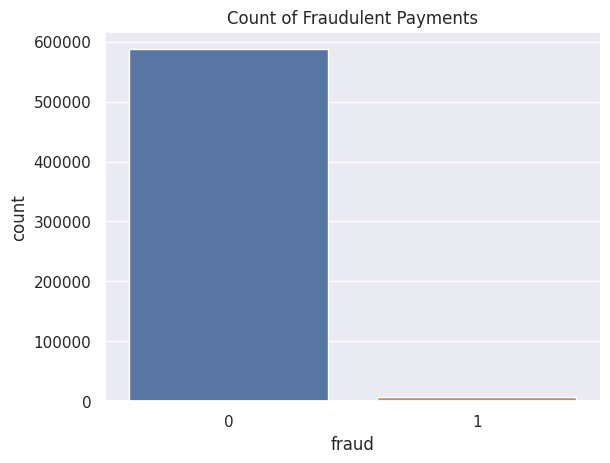

Number of normal examples:  587443
Number of fradulent examples:  7200


In [7]:
# Create two dataframes with fraud and non-fraud data 
df_fraud = data.loc[data.fraud == 1] 
df_non_fraud = data.loc[data.fraud == 0]

sns.countplot(x="fraud",data=data)
plt.title("Count of Fraudulent Payments")
plt.show()
print("Number of normal examples: ",df_non_fraud.fraud.count())
print("Number of fradulent examples: ",df_fraud.fraud.count())

We can see the mean amount and fraud percent by category below. Looks like leisure and the travel is the most selected categories for fraudsters. Fraudsters chose the categories which people spend more on average. Let's confirm this hypothesis by checking the fraud and non-fraud amount transacted.



In [8]:
print("Mean feature values per category",data.groupby('category')['amount','fraud'].mean())

Mean feature values per category                             amount     fraud
category                                    
es_barsandrestaurants    43.461014  0.018829
es_contents              44.547571  0.000000
es_fashion               65.666642  0.017973
es_food                  37.070405  0.000000
es_health               135.621367  0.105126
es_home                 165.670846  0.152064
es_hotelservices        205.614249  0.314220
es_hyper                 45.970421  0.045917
es_leisure              288.911303  0.949900
es_otherservices        135.881524  0.250000
es_sportsandtoys        215.715280  0.495252
es_tech                 120.947937  0.066667
es_transportation        26.958187  0.000000
es_travel              2250.409190  0.793956
es_wellnessandbeauty     65.511221  0.047594


Our hypothesis for fraudsters choosing the categories which people spend more is only partly correct, but as we can see in the table below we can say confidently say that a fraudulent transaction will be much more (about four times or more) than average for that category.



In [9]:
# Create two dataframes with fraud and non-fraud data 
pd.concat([df_fraud.groupby('category')['amount'].mean(),df_non_fraud.groupby('category')['amount'].mean(),\
           data.groupby('category')['fraud'].mean()*100],keys=["Fraudulent","Non-Fraudulent","Percent(%)"],axis=1,\
          sort=False).sort_values(by=['Non-Fraudulent'])

,Fraudulent,Non-Fraudulent,Percent(%)
category,,,
es_transportation,NaN,26.958187,0.000000
es_food,NaN,37.070405,0.000000
es_hyper,169.255429,40.037145,4.591669
es_barsandrestaurants,164.092667,41.145997,1.882944
es_contents,NaN,44.547571,0.000000
es_wellnessandbeauty,229.422535,57.320219,4.759380
es_fashion,247.008190,62.347674,1.797335
es_leisure,300.286878,73.230400,94.989980
es_otherservices,316.469605,75.685497,25.000000


Average amount spend it categories are similar; between 0-500 discarding the outliers, except for the travel category which goes very high.

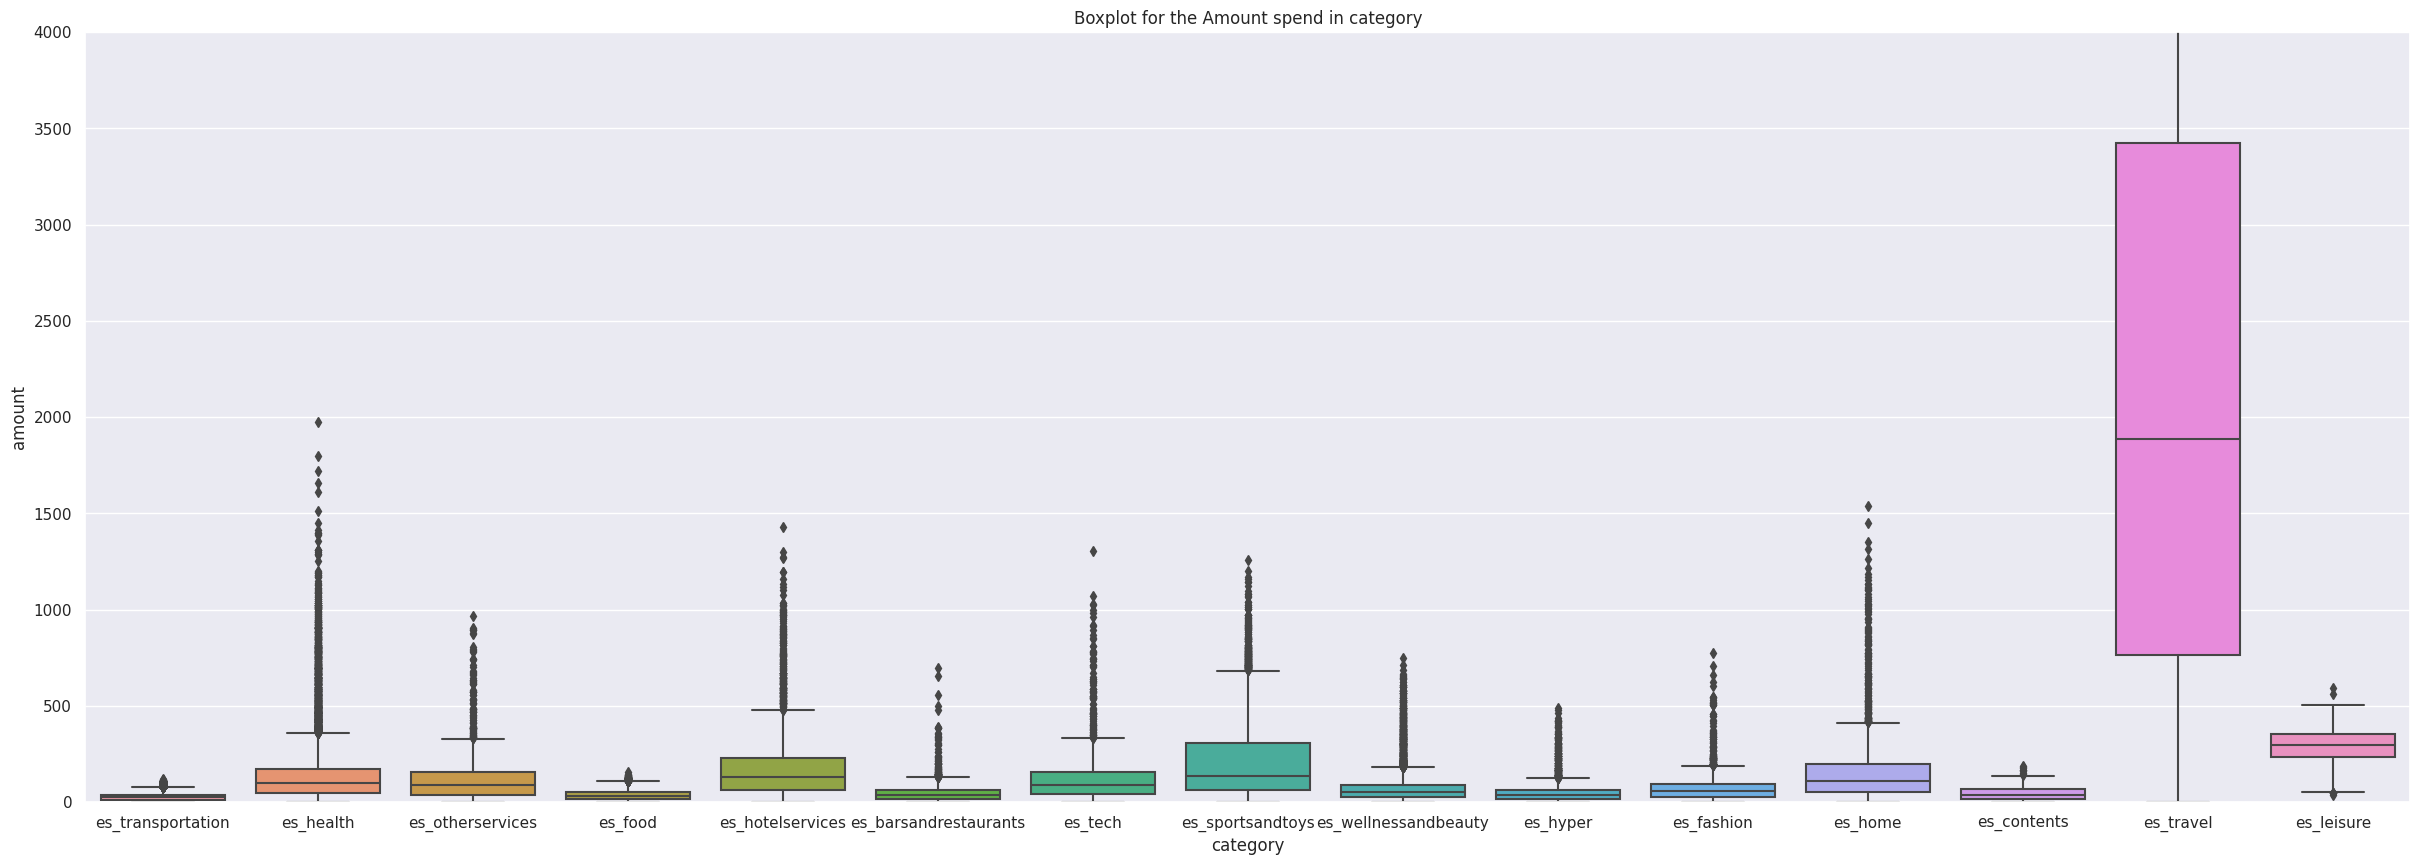

In [10]:
# Plot histograms of the amounts in fraud and non-fraud data 
plt.figure(figsize=(30,10))
sns.boxplot(x=data.category,y=data.amount)
plt.title("Boxplot for the Amount spend in category")
plt.ylim(0,4000)
plt.show()

Again we can see in the histogram below the fradulent transactions are less in count but more in amount.



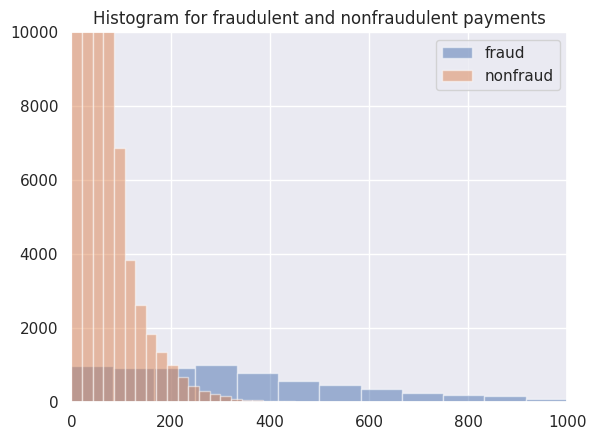

In [11]:
# Plot histograms of the amounts in fraud and non-fraud data 
plt.hist(df_fraud.amount, alpha=0.5, label='fraud',bins=100)
plt.hist(df_non_fraud.amount, alpha=0.5, label='nonfraud',bins=100)
plt.title("Histogram for fraudulent and nonfraudulent payments")
plt.ylim(0,10000)
plt.xlim(0,1000)
plt.legend()
plt.show()

In [12]:
print((data.groupby('age')['fraud'].mean()*100).reset_index().rename(columns={'age':'Age','fraud' : 'Fraud Percent'}).sort_values(by='Fraud Percent'))

  Age  Fraud Percent
7   U       0.594228
6   6       0.974826
5   5       1.095112
1   1       1.185254
3   3       1.192815
2   2       1.251401
4   4       1.293281
0   0       1.957586


## **Data Preprocessing**

In this part we will preprocess the data and prepare for the training.

There are only one unique zipCode values so we will drop them.


In [13]:
print("Unique zipCodeOri values: ",data.zipcodeOri.nunique())
print("Unique zipMerchant values: ",data.zipMerchant.nunique())
# dropping zipcodeori and zipMerchant since they have only one unique value
data_reduced = data.drop(['zipcodeOri','zipMerchant'],axis=1)

Unique zipCodeOri values:  1
Unique zipMerchant values:  1


## **Checking the data after dropping.**



In [14]:
data_reduced.columns

Index(['step', 'customer', 'age', 'gender', 'merchant', 'category', 'amount',
       'fraud'],
      dtype='object')

Here we will transform categorical features into numerical values. It is usually better to turn these type of categorical values into dummies because they have no relation in size(i.e. customer1 is not greater than customer2) but since they are too many (over 500k customers and merchants) the features will grow 10^5 in size and it will take forever to train. I've put the code below for turning categorical features into dummies if you want to give it a try.



In [15]:
data_reduced.loc[:,['customer','merchant','category']].astype('category')
# data_dum = pd.get_dummies(data_reduced.loc[:,['customer','merchant','category','gender']],drop_first=True) 
# print(data_dum.info())

,customer,merchant,category
0,C1093826151,M348934600,es_transportation
1,C352968107,M348934600,es_transportation
2,C2054744914,M1823072687,es_transportation
3,C1760612790,M348934600,es_transportation
4,C757503768,M348934600,es_transportation
...,...,...,...
594638,C1753498738,M1823072687,es_transportation
594639,C650108285,M1823072687,es_transportation
594640,C123623130,M349281107,es_fashion
594641,C1499363341,M1823072687,es_transportation


In [16]:
print(data.isnull().sum())

step           0
customer       0
age            0
gender         0
zipcodeOri     0
merchant       0
zipMerchant    0
category       0
amount         0
fraud          0
dtype: int64


In [17]:
# turning object columns type to categorical for easing the transformation process
col_categorical = data_reduced.select_dtypes(include= ['object']).columns
for col in col_categorical:
    data_reduced[col] = data_reduced[col].astype('category')
# categorical values ==> numeric values
data_reduced[col_categorical] = data_reduced[col_categorical].apply(lambda x: x.cat.codes)
data_reduced.head(5)

,step,customer,age,gender,merchant,category,amount,fraud
0,0,210,4,2,30,12,4.55,0
1,0,2753,2,2,30,12,39.68,0
2,0,2285,4,1,18,12,26.89,0
3,0,1650,3,2,30,12,17.25,0
4,0,3585,5,2,30,12,35.72,0


## **Let's define our independent variable : X and dependant/target variable y**



In [18]:
X = data_reduced.drop(['fraud'],axis=1)
y = data['fraud']
print(X.head(),"\n")
print(y.head())

   step  customer  age  gender  merchant  category  amount
0     0       210    4       2        30        12    4.55
1     0      2753    2       2        30        12   39.68
2     0      2285    4       1        18        12   26.89
3     0      1650    3       2        30        12   17.25
4     0      3585    5       2        30        12   35.72 

0    0
1    0
2    0
3    0
4    0
Name: fraud, dtype: int64


In [19]:
y[y==1].count()

7200

##  **Oversampling with SMOTE**
1. Using SMOTE (Synthetic Minority Oversampling Technique) for balancing the dataset. 
2. Resulted counts show that now we have exact number of class instances (1 and 0).

In [20]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)
y_res = pd.DataFrame(y_res)
print(y_res.value_counts())


fraud
0        587443
1        587443
dtype: int64


## **Train Test**
I will do a train test split for measuring the performance. I haven't done cross validation since we have a lot of instances and i don't want to wait that much for training but it should be better to cross validate most of the times.



In [21]:
# I won't do cross validation since we have a lot of instances
X_train, X_test, y_train, y_test = train_test_split(X_res,y_res,test_size=0.3,random_state=42,shuffle=True,stratify=y_res)
print(X_train, X_test, y_train, y_test )

         step  customer  age  gender  merchant  category       amount
903303    150      1005    3       1        35         4   318.801009
721176     63       496    2       1        49        10   607.125045
680561     82      2421    2       1        21         9   326.437076
1154749    18       598    4       1        40        13  2086.201087
752766     55      2809    1       1        42         5  1141.199516
...       ...       ...  ...     ...       ...       ...          ...
705232     57      2498    1       1        42         7    90.072915
652698     66      2127    3       1        34         4    77.633917
465780    145      2993    2       1        18        12     4.260000
246158     82      3418    2       2        18        12    32.800000
899256     50      1249    3       1        47         9   157.757617

[822420 rows x 7 columns]          step  customer  age  gender  merchant  category      amount
1108619    54       693    2       1        40         9  408.15

As i talked about it before fraud datasets will be imbalanced and most of the instances will be non-fraudulent. Imagine that we have the dataset here and we are always predicting non-fraudulent. Our accuracy would be almost 99 % for this dataset and mostly for others as well since fraud percentage is very low. Our accuracy is very high but we are not detecting any frauds so it is a useless classifier. So the base accuracy score should be better at least than predicting always non-fraudulent for performing a detection.



In [22]:
# The base score should be better than predicting always non-fraduelent
print("Base accuracy score we must beat is: ", 
      df_non_fraud.fraud.count()/ np.add(df_non_fraud.fraud.count(),df_fraud.fraud.count()) * 100)

Base accuracy score we must beat is:  98.7891894800746


##  **K-Neighbours Classifier**

Classification Report for K-Nearest Neighbours: 
               precision    recall  f1-score   support

           0       1.00      0.98      0.99    176233
           1       0.98      1.00      0.99    176233

    accuracy                           0.99    352466
   macro avg       0.99      0.99      0.99    352466
weighted avg       0.99      0.99      0.99    352466

Confusion Matrix of K-Nearest Neigbours: 
 [[171999   4234]
 [   362 175871]]


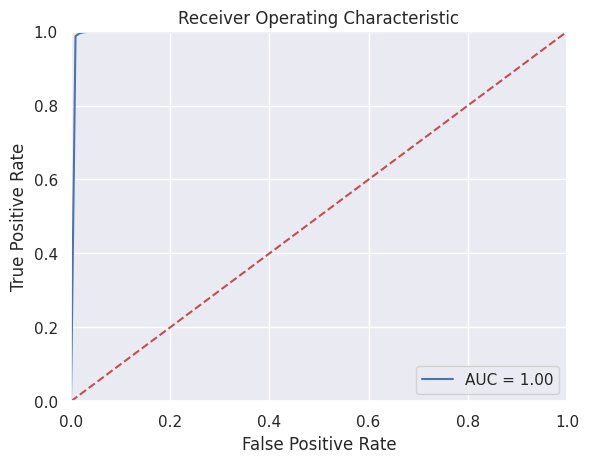

Accuracy: 98.70%
Model path========> ./source/K-NearestNeighbours_classifier_finalized_model_v.0.0.1.pkl
[model_file_path]========================>: ./source/K-NearestNeighbours_classifier_finalized_model_v.0.0.1.pkl
MINIO_CLIENT=======> <minio.api.Minio object at 0x7f2d5332ce80>
filename===========> ./source/K-NearestNeighbours_classifier_finalized_model_v.0.0.1.pkl
model_name=========> K-Nearest
output_bucket======> experiments
s3_path============> banking/pickels/neigbors/model/
head =======> ./source
tail =======> K-NearestNeighbours_classifier_finalized_model_v.0.0.1.pkl
file_size======> 63934059


2023-03-23 16:25:19.270 650 urllib3.connectionpool WARNING [_put_conn():305] Connection pool is full, discarding connection: home.hpe-staging-ezaf.com. Connection pool size: 1
2023-03-23 16:25:19.559 650 urllib3.connectionpool WARNING [_put_conn():305] Connection pool is full, discarding connection: home.hpe-staging-ezaf.com. Connection pool size: 1
2023-03-23 16:25:19.564 650 urllib3.connectionpool WARNING [_put_conn():305] Connection pool is full, discarding connection: home.hpe-staging-ezaf.com. Connection pool size: 1
2023-03-23 16:25:19.644 650 urllib3.connectionpool WARNING [_put_conn():305] Connection pool is full, discarding connection: home.hpe-staging-ezaf.com. Connection pool size: 1
2023-03-23 16:25:19.678 650 urllib3.connectionpool WARNING [_put_conn():305] Connection pool is full, discarding connection: home.hpe-staging-ezaf.com. Connection pool size: 1


The Fraud indentification modle K-Nearest classifier finalized model Upload Completed!


In [23]:
#K-ello Neigbors
xtrain, xtest, ytrain, ytest=train_test_split(X_res, y_res, test_size=0.3,random_state=42,shuffle=True,stratify=y_res)

knn = KNeighborsClassifier(n_neighbors=5,p=1)
knn.fit(xtrain, np.ravel(ytrain,order='C'))
y_pred = knn.predict(xtest)


print("Classification Report for K-Nearest Neighbours: \n", classification_report(ytest, y_pred))
print("Confusion Matrix of K-Nearest Neigbours: \n", confusion_matrix(ytest,y_pred))
plot_roc_auc(ytest, knn.predict_proba(xtest)[:,1])

# Get accuracy
accuracy = accuracy_score(ytest, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# save the model to minio s3 object
# filename = f"{_decode(configuration_dtl.get('OUTPUT_DIR_PATH'))}{configuration_dtl.get('KNC_MODEL')}{configuration_dtl.get('MODEL_VERSION')}{configuration_dtl.get('EXT')}"
filename = "model.pkl"
print("Model path========>", filename)
pickle.dump(knn, open(f"{filename}", "wb"))
model_file_path = os.path.join(filename)
print("[model_file_path]========================>:",model_file_path)

MINIO_CLIENT_KNN = Minio(
    endpoint= _decode(configuration_dtl.get('MINIO_HOST_URL')).replace("https://",""), 
    access_key=_decode(configuration_dtl.get('MINIO_ACCESS_KEY')), 
    secret_key=_decode(configuration_dtl.get('MINIO_SECRET_KEY')),
    secure=True,
    http_client = urllib3.PoolManager(cert_reqs='CERT_NONE'))

print("MINIO_CLIENT", MINIO_CLIENT_KNN)

#upload into storage
cwd = os.getcwd()
_set_object(f"{filename}", "K-Nearest", MINIO_CLIENT_KNN, "experiments", "banking/pickels/neigbors/model/")

##  **Random Forest Classifier**

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   58.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.1s finished


Classification Report for Random Forest Classifier: 
               precision    recall  f1-score   support

           0       0.99      0.97      0.98    176233
           1       0.97      0.99      0.98    176233

    accuracy                           0.98    352466
   macro avg       0.98      0.98      0.98    352466
weighted avg       0.98      0.98      0.98    352466

Confusion Matrix of Random Forest Classifier: 
 [[170106   6127]
 [  1079 175154]]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.1s finished


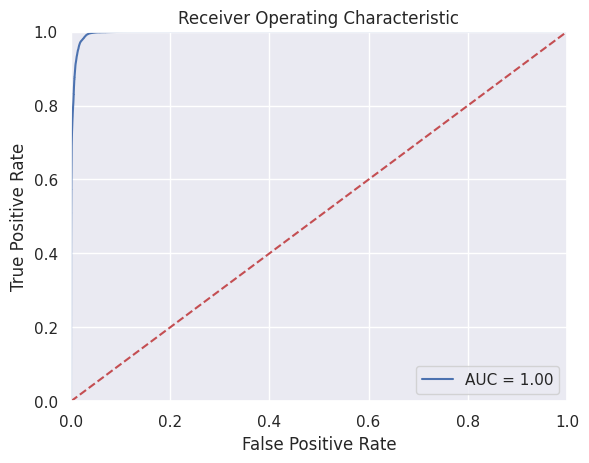

Accuracy: 97.96%
[model_file_path]========================>: ./source/RandomForest_classifier_finalized_model_v.0.0.1.pkl
MINIO_CLIENT=======> <minio.api.Minio object at 0x7f2d5332ce80>
filename===========> ./source/RandomForest_classifier_finalized_model_v.0.0.1.pkl
model_name=========> Random
output_bucket======> experiments
s3_path============> banking/pickels/random/model/
head =======> ./source
tail =======> RandomForest_classifier_finalized_model_v.0.0.1.pkl
file_size======> 2613990
The Fraud indentification modle Random classifier finalized model Upload Completed!


In [24]:
#Random Forest Classifier
xtrain, xtest, ytrain, ytest=train_test_split(X_res, y_res, test_size=0.3,random_state=42,shuffle=True,stratify=y_res)
rf_clf = RandomForestClassifier(n_estimators=100,
                                max_depth=8,
                                random_state=42,
                                verbose=1,class_weight="balanced")
rf_clf.fit(xtrain, ytrain.values.ravel())
y_pred = rf_clf.predict(xtest)

print("Classification Report for Random Forest Classifier: \n", classification_report(ytest, y_pred))
print("Confusion Matrix of Random Forest Classifier: \n", confusion_matrix(ytest,y_pred))
plot_roc_auc(ytest, rf_clf.predict_proba(xtest)[:,1])

# Get accuracy
accuracy = accuracy_score(ytest, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# save the model to minio s3 object
# filename = f"{_decode(configuration_dtl.get('OUTPUT_DIR_PATH'))}{configuration_dtl.get('RFC_MODEL')}{configuration_dtl.get('MODEL_VERSION')}{configuration_dtl.get('EXT')}"
filename = "model.pkl"
model_file_path = os.path.join(filename)
pickle.dump(rf_clf, open(f"{filename}", "wb"))
print("[model_file_path]========================>:",model_file_path)

MINIO_CLIENT_RND = Minio(
    endpoint= _decode(configuration_dtl.get('MINIO_HOST_URL')).replace("https://",""), 
    access_key=_decode(configuration_dtl.get('MINIO_ACCESS_KEY')), 
    secret_key=_decode(configuration_dtl.get('MINIO_SECRET_KEY')),
    secure=True,
    http_client = urllib3.PoolManager(cert_reqs='CERT_NONE'))

print("MINIO_CLIENT", MINIO_CLIENT_RND)

#upload into storage
cwd = os.getcwd()
_set_object(f"{filename}", "Random", MINIO_CLIENT_RND, "experiments", "banking/pickels/random/model/")

##  **XGBoost Classifier**


Classification Report for XGBoost: 
               precision    recall  f1-score   support

           0       1.00      0.99      0.99    176233
           1       0.99      1.00      0.99    176233

    accuracy                           0.99    352466
   macro avg       0.99      0.99      0.99    352466
weighted avg       0.99      0.99      0.99    352466

Confusion Matrix of  : 
 [[174096   2137]
 [   738 175495]]


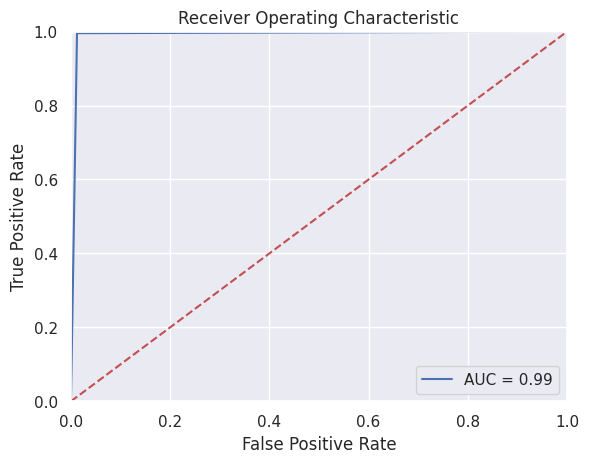

Accuracy: 99.18%
MINIO_CLIENT=======> <minio.api.Minio object at 0x7f2d5332ce80>
filename===========> ./source/xgboost_classifier_finalized_model_v.0.0.1.pkl
model_name=========> XGBoost
output_bucket======> experiments
s3_path============> banking/pickels/xgboost/model/
head =======> ./source
tail =======> xgboost_classifier_finalized_model_v.0.0.1.pkl
file_size======> 1513326
The Fraud indentification modle XGBoost classifier finalized model Upload Completed!


In [25]:
xtrain, xtest, ytrain, ytest=train_test_split(X_res, y_res, test_size=0.3,random_state=42,shuffle=True,stratify=y_res)

XGBoost_CLF = xgb.XGBClassifier(silent=None, seed=42, colsample_bynode=1, max_depth=6, learning_rate=0.05, n_estimators=400, 
                                objective="binary:hinge", booster='gbtree', missing=1,
                                n_jobs=-1, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0, 
                                subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, 
                                base_score=0.5, random_state=42, verbosity=1)
XGBoost_CLF.fit(xtrain,ytrain)
y_pred = XGBoost_CLF.predict(xtest)

print("Classification Report for XGBoost: \n", classification_report(ytest, y_pred))
print("Confusion Matrix of  : \n", confusion_matrix(ytest,y_pred))
plot_roc_auc(ytest, XGBoost_CLF.predict_proba(xtest)[:,1])

# Get accuracy
accuracy = accuracy_score(ytest, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# save the model to minio s3 object
filename = f"{_decode(configuration_dtl.get('OUTPUT_DIR_PATH'))}{configuration_dtl.get('XGB_MODEL')}{configuration_dtl.get('MODEL_VERSION')}{configuration_dtl.get('EXT')}"
filename = "model.pkl"
pickle.dump(XGBoost_CLF, open(f"{filename}", "wb"))

MINIO_CLIENT_XGB = Minio(
    endpoint= _decode(configuration_dtl.get('MINIO_HOST_URL')).replace("https://",""), 
    access_key=_decode(configuration_dtl.get('MINIO_ACCESS_KEY')), 
    secret_key=_decode(configuration_dtl.get('MINIO_SECRET_KEY')),
    secure=True,
    http_client = urllib3.PoolManager(cert_reqs='CERT_NONE'))

print("MINIO_CLIENT", MINIO_CLIENT_XGB)

#upload into storage
cwd = os.getcwd()
_set_object(f"{filename}", "XGBoost", MINIO_CLIENT_XGB, "experiments", "banking/pickels/xgboost/model/")

##  **Logistic Regression Classifier**


Classification Report for LogisticRegression: 
               precision    recall  f1-score   support

           0       0.90      0.95      0.92    176233
           1       0.95      0.89      0.92    176233

    accuracy                           0.92    352466
   macro avg       0.92      0.92      0.92    352466
weighted avg       0.92      0.92      0.92    352466

Confusion Matrix of LogisticRegression: 
 [[167538   8695]
 [ 19062 157171]]


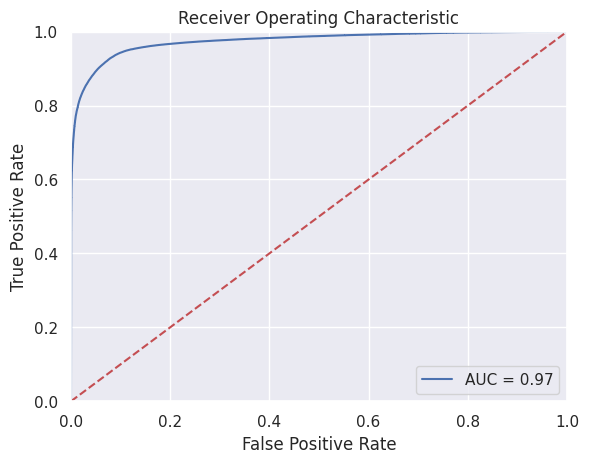

Accuracy: 92.12%
[model_file_path]========================>: ./source/LogisticRegression_classifier_finalized_model_v.0.0.1.pkl
MINIO_CLIENT=======> <minio.api.Minio object at 0x7f2d5332ce80>
filename===========> ./source/LogisticRegression_classifier_finalized_model_v.0.0.1.pkl
model_name=========> LogisticRegression
output_bucket======> experiments
s3_path============> banking/pickels/logisticregression/model/
head =======> ./source
tail =======> LogisticRegression_classifier_finalized_model_v.0.0.1.pkl
file_size======> 916
The Fraud indentification modle LogisticRegression classifier finalized model Upload Completed!


In [26]:
xtrain, xtest, ytrain, ytest = train_test_split(X_res, y_res, test_size=0.3, random_state=42, shuffle=True, stratify=y_res)
LRmodel = LogisticRegression(max_iter=999,solver='lbfgs')
LRmodel.fit(xtrain, ytrain)

# Get predictions
y_pred = LRmodel.predict(xtest)
print("Classification Report for LogisticRegression: \n", classification_report(ytest, y_pred))
print("Confusion Matrix of LogisticRegression: \n", confusion_matrix(ytest,y_pred))
plot_roc_auc(ytest, LRmodel.predict_proba(xtest)[:,1])

# Get accuracy
accuracy = accuracy_score(ytest, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# save the model to minio s3 object
filename = f"{_decode(configuration_dtl.get('OUTPUT_DIR_PATH'))}{configuration_dtl.get('LRC_MODEL')}{configuration_dtl.get('MODEL_VERSION')}{configuration_dtl.get('EXT')}"
filename = "model.pkl"
model_file_path = os.path.join(filename)
pickle.dump(LRmodel, open(f"{filename}", "wb"))

# joblib.dump(LRmodel, open(filename, 'wb'))
print("[model_file_path]========================>:",model_file_path)

MINIO_CLIENT_LRC = Minio(
    endpoint= _decode(configuration_dtl.get('MINIO_HOST_URL')).replace("https://",""), 
    access_key=_decode(configuration_dtl.get('MINIO_ACCESS_KEY')), 
    secret_key=_decode(configuration_dtl.get('MINIO_SECRET_KEY')),
    secure=True,
    http_client = urllib3.PoolManager(cert_reqs='CERT_NONE'))

print("MINIO_CLIENT", MINIO_CLIENT_LRC)

#upload into storage
cwd = os.getcwd()
_set_object(f"{filename}", "LogisticRegression", MINIO_CLIENT_LRC, "experiments", "banking/pickels/logisticregression/model/")

## **Model Deployment**

## Note ::
1. Here we are creating the secrets and configuration server accounts traditionally.

In [22]:

default_model_spec = V1beta1InferenceServiceSpec(predictor=V1beta1PredictorSpec(
    service_account_name=configuration_dtl.get('service_account_name'),
    sklearn=V1beta1SKLearnSpec(
        storage_uri=configuration_dtl.get('storage_uri'),
        protocol_version=configuration_dtl.get('protocol_version')
    )))

isvc = V1beta1InferenceService(api_version=constants.KSERVE_V1BETA1,
                          kind=constants.KSERVE_KIND,
                          metadata=client.V1ObjectMeta(name=configuration_dtl.get('KSERVE_MODEL_NAME'), namespace=configuration_dtl.get('NAMESPACE')),
                          spec=default_model_spec)


kserve = KServeClient()
kserve.create(isvc)

{'apiVersion': 'serving.kserve.io/v1beta1',
 'kind': 'InferenceService',
 'metadata': {'creationTimestamp': '2023-03-27T18:30:14Z',
  'generation': 1,
  'labels': {'modelClass': 'mlserver_sklearn.SKLearnModel'},
  'managedFields': [{'apiVersion': 'serving.kserve.io/v1beta1',
    'fieldsType': 'FieldsV1',
    'fieldsV1': {'f:spec': {'.': {},
      'f:predictor': {'.': {},
       'f:serviceAccountName': {},
       'f:sklearn': {'.': {},
        'f:name': {},
        'f:protocolVersion': {},
        'f:storageUri': {}}}}},
    'manager': 'OpenAPI-Generator',
    'operation': 'Update',
    'time': '2023-03-27T18:30:11Z'}],
  'name': 'fraud-detection-lr-27032023',
  'namespace': 'hpedemo-user01',
  'resourceVersion': '74041608',
  'uid': '368f22d6-0850-409d-9216-75691bb5b192'},
 'spec': {'predictor': {'model': {'env': [{'name': 'MLSERVER_MODEL_NAME',
      'value': 'fraud-detection-lr-27032023'},
     {'name': 'MLSERVER_MODEL_URI', 'value': '/mnt/models'}],
    'modelFormat': {'name': 'skle

## **Prediction**

In [27]:
#---------------- ::: get-generated-data-test ::: ----------------
MINIO_CLIENT_INFR = Minio(
    endpoint= _decode(configuration_dtl.get('MINIO_HOST_URL')).replace("https://",""), 
    access_key=_decode(configuration_dtl.get('MINIO_ACCESS_KEY')), 
    secret_key=_decode(configuration_dtl.get('MINIO_SECRET_KEY')),
    secure=True,
    http_client = urllib3.PoolManager(cert_reqs='CERT_NONE'))

print("MINIO_CLIENT", MINIO_CLIENT_INFR)
# data = pd.read_csv("./source/generated-data.csv")
csv_file = MINIO_CLIENT_INFR.get_object("experiments", configuration_dtl.get('GENERATED_PATH'))
data = pd.read_csv(csv_file)
data.head(5)
data_reduced = data.drop(['zipcodeOri','zipMerchant'],axis=1)
data_reduced.loc[:,['customer','merchant','category']].astype('category')

# turning object columns type to categorical for easing the transformation process
col_categorical = data_reduced.select_dtypes(include= ['object']).columns
for col in col_categorical:
    data_reduced[col] = data_reduced[col].astype('category')
data_reduced[col_categorical] = data_reduced[col_categorical].apply(lambda x: x.cat.codes)
data_reduced.head(5)

#---------------- ::: inference input ::: ----------------
# In contrast, model inference is the process of using a trained model to infer a result from live data.
X = data_reduced.drop(['fraud'], axis=1)
y = data_reduced['fraud']
print("shape==============", [len(X.values), len(X.values[0])])
print("X.values[0]==============", X.values[0], "=======",  list(X.values[0]))

inference_request = {
    "inputs" : [{
        "name" : "fraud-detection-infer-001",
        "datatype": "FP32",
        # !!! Multiple record infer !!!
        # "data": [list(item) for item in X.values],
        # "shape": [len(X.values), len(X.values[0])],
 
        # !!! One record infer !!!
        "shape": [1, 7],
        # "data": [list(item) for item in X.values][14], #Non-Fraud Transaction Dtls
        "data": [list(item) for item in X.values][17], #Fraud Transaction Dtls
    }]
}
print("data::", inference_request)

#---------------- ::: Trigger Kserving ::: ----------------
KServe = KServeClient()
# obj_kserve = KServe.get(configuration_dtl.get('KSERVE_MODEL_NAME'), namespace=configuration_dtl.get('NAMESPACE'))
# print(dict(obj_kserve))

# local_isvc_resp = KServe.get(configuration_dtl.get('KSERVE_MODEL_NAME'), namespace=configuration_dtl.get('NAMESPACE')).get("status").get("components").get("predictor").get("address").get("url")
# print("local_isvc_resp", local_isvc_resp)
# print("inference::", f"{local_isvc_resp}/v2/models/{configuration_dtl.get('KSERVE_MODEL_NAME')}/infer")

server_isvc_resp = KServe.get(configuration_dtl.get('KSERVE_MODEL_NAME'), namespace=configuration_dtl.get('NAMESPACE')).get("status").get("components").get('predictor').get('url').replace("http","https")
print("server_isvc_resp", server_isvc_resp)
print("inference::", f"{server_isvc_resp}/v2/models/{configuration_dtl.get('KSERVE_MODEL_NAME')}/infer")

session = requests.Session()
message = {"message":"", "value":""}
response = session.post(
    f"{server_isvc_resp}/v2/models/{configuration_dtl.get('KSERVE_MODEL_NAME')}/infer",
    json = inference_request,
    verify=False)
if response.status_code == 200:
    if json.loads(response.__dict__.get('_content')).get('outputs')[0]['data'][0] != None and json.loads(response.__dict__.get('_content')).get('outputs')[0]['data'][0] == 1:
        message['message'] = "Fraud Banking Transaction !"
        message['value'] = json.loads(response.__dict__.get('_content')).get('outputs')[0]['data'][0]        
        print('\033[91m' "Prediction Result:", json.dumps(message))
    elif len(json.loads(response.__dict__.get('_content')).get('outputs')[0]['data'])>1:
        print("Model-Infer-dtl:[data]:\n", json.loads(response.__dict__.get('_content')).get('outputs')[0]['data'])
    else:
        message['message'] = "Non-fraud Banking Transaction !"
        message['value'] = json.loads(response.__dict__.get('_content')).get('outputs')[0]['data'][0]   
        print('\033[92m'  "Prediction Result:", json.dumps(message))
else:
    print("service issue::", response.status_code)
    print("service issue::", response.content)

MINIO_CLIENT <minio.api.Minio object at 0x7fa098066130>
shape============== [20, 7]
X.values[0]============== [ 0.   10.    3.    0.    1.    2.   10.59] ======= [0.0, 10.0, 3.0, 0.0, 1.0, 2.0, 10.59]
data:: {'inputs': [{'name': 'fraud-detection-infer-001', 'datatype': 'FP32', 'shape': [1, 7], 'data': [1.0, 4.0, 4.0, 0.0, 4.0, 1.0, 255.14]}]}
server_isvc_resp https://fraud-detection-lr-27032023-predictor-default.hpedemo-user01.hpe-staging-ezaf.com
inference:: https://fraud-detection-lr-27032023-predictor-default.hpedemo-user01.hpe-staging-ezaf.com/v2/models/fraud-detection-lr-27032023/infer
Prediction Result: {"message": "Fraud Banking Transaction !", "value": 1}


## **Conclusion::**
In this kernel we have tried to do fraud detection on a bank payment data and we have achieved remarkable results with our classifiers. Since fraud datasets have an imbalance class problem we performed an oversampling technique called SMOTE and generated new minority class examples. I haven't put the classification results without SMOTE here but i added them in my github repo before so if you are interested to compare both results you can also check my github repo.

Thanks for taking the time to read or just view the results from my first kernel i hope you enjoyed it. I would be grateful for any kind of critique, suggestion or comment and i wish you to have a great day with lots of beautiful data!

# **Reference::**

1. Lavion, Didier; et al, "PwC's Global Economic Crime and Fraud Survey 2022", 
2. https://www.pwc.com/gx/en/services/forensics/economic-crime-survey.html |
3. https://www.pwc.com/gx/en/services/forensics/gecs/outcomes-of-platform-fraud.svg |
4. https://www.pwc.com/gx/en/forensics/gecsm-2022/pdf/PwC%E2%80%99s-Global-Economic-Crime-and-Fraud-Survey-2022.pdf **(pdf) | PwC.com. Retrieved PwC’s Global Economic Crime and Fraud Survey 2022 **

5. SMOTE: Synthetic Minority Over-sampling Technique, https://jair.org/index.php/jair/article/view/10302

6. Banksim Data Set,paper http://www.msc-les.org/proceedings/emss/2014/EMSS2014_144.pdf **(pdf)**